In [9]:
%pip install git+https://github.com/forrestbao/pyeeg.git

  Cloning https://github.com/forrestbao/pyeeg.git to /tmp/pip-req-build-xb3cmsj3
  Running command git clone --filter=blob:none --quiet https://github.com/forrestbao/pyeeg.git /tmp/pip-req-build-xb3cmsj3
  Resolved https://github.com/forrestbao/pyeeg.git to commit a6c18bb093e4748f9d9c208535a6ae024a0802b8
  Preparing metadata (setup.py) ... done
Note: you may need to restart the kernel to use updated packages.


In [10]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt 
import scipy.stats as stats 
import pyeeg 

from model.fgn import fractional_gaussian_covariance_series
from copulas.visualization import compare_3d

class FBm():

    def generate_gaussian_fBm(self, H1: float, H2: float, corr:float, size: int, drifts: list = [0.0, 0.0]) -> np.ndarray:

        means = np.zeros(2*size)     
        means[0:size] = means[0:size] + drifts[0]
        means[size:] = means[size:] + drifts[1]
                         
        result = np.random.multivariate_normal(means, 
                                               fractional_gaussian_covariance_series(size, H1, H2, corr))
        ts = np.ndarray((2, size))
        ts[0] = result[0:size]
        ts[1] = result[size:]

        return np.cumsum(np.insert(ts, 0, 0, axis=1), axis=1) 
    
    def hurst(self, X):
        return pyeeg.hurst(X) 

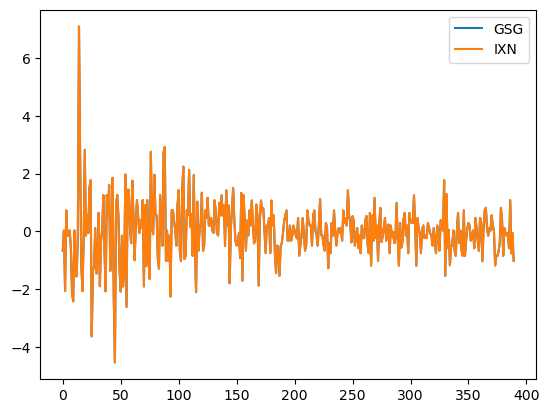

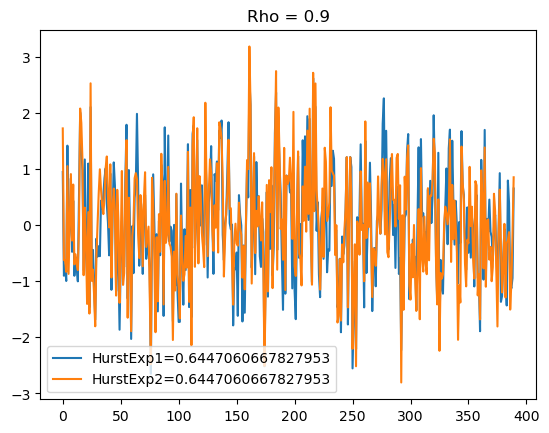

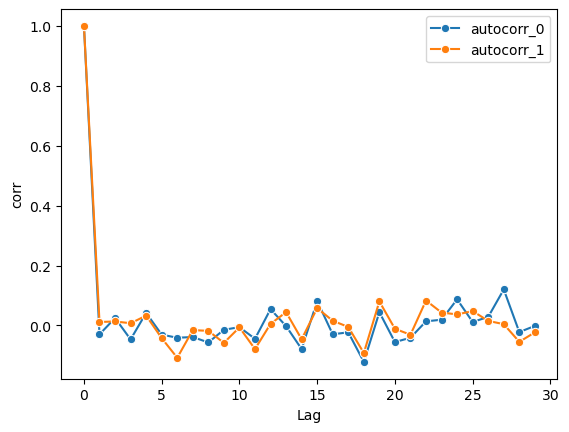

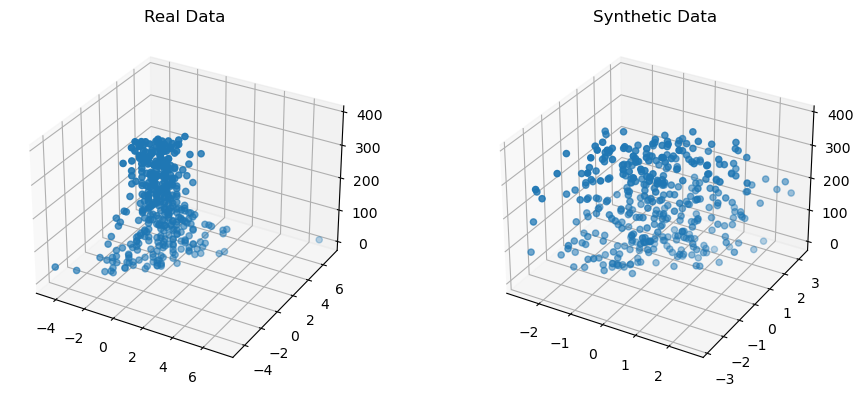

In [11]:
import pandas as pd 
tlt = pd.read_csv('./data/TLT_sample.csv')
tlt['marketClose'] = tlt['marketClose'].apply(np.log).diff().dropna()

mean0 = np.mean(tlt['marketClose']) 
mean1 = np.mean(tlt['marketClose'])
rho = 0.9

fbm = FBm()
H1 = fbm.hurst(tlt['marketClose'].dropna().values)
H2 = fbm.hurst(tlt['marketClose'].dropna().values)

size = len(tlt) - 1

ts = fbm.generate_gaussian_fBm(H1, H2, rho, size, [mean0, mean1]) 

plt.plot(stats.zscore(tlt['marketClose'].dropna().values), label=f"GSG")
plt.plot(stats.zscore(tlt['marketClose'].dropna().values), label=f"IXN")
plt.legend()
plt.show()

plt.plot(stats.zscore(np.diff(ts[0])), label=f"HurstExp1={H1}")
plt.plot(stats.zscore(np.diff(ts[1])), label=f"HurstExp2={H2}")
plt.title(f"Rho = {rho}")
plt.legend()
plt.show()

autocorr_df = pd.DataFrame()
autocorr_df['decay_0'] = np.diff(ts[0])
autocorr_df['decay_1'] = np.diff(ts[1])
decay_func = lambda S, _range: [S.apply(abs).autocorr(lag=Lag) for Lag in _range]

sns.lineplot(data=decay_func(autocorr_df['decay_0'], range(0, 30)), label='autocorr_0', marker='o')
sns.lineplot(data=decay_func(autocorr_df['decay_1'], range(0, 30)), label='autocorr_1', marker='o')
plt.xlabel('Lag')
plt.ylabel('corr')
plt.show()

three_df = pd.DataFrame() 
three_df['x'] = stats.zscore(np.diff(ts[0]))
three_df['y'] = stats.zscore(np.diff(ts[1]))
three_df['z'] = range(size)

orig_three_df = pd.DataFrame()
orig_three_df['x'] = stats.zscore(tlt['marketClose'].dropna().values)
orig_three_df['y'] = stats.zscore(tlt['marketClose'].dropna().values)
orig_three_df['z'] = range(len(tlt)-1)

compare_3d(orig_three_df, three_df)